# **Práctica 2**

En esta práctica vamos a ver como podríamos trabajar con redes neuronales totalmente conectadas en imagen. Veremos cuales son las limitaciones de emplear este tipo de arquitecturas para trabajar con imágenes.


En primer lugar vamos a trabajar con el dataset MNIST para clasificación de imágenes de dígitos numéricos. Para ello seguiremos los siguientes pasos:



1.   Descargaremos las imágenes y las visualizaremos
2.   Pre-procesaremos los datos.
3.   Diseñaremos la arquitectura.
4.   Entrenaremos la red.
5.   Evaluaremos el modelo entrenado.



# 1. Descaga de las imágenes y visualización

In [2]:
# Importamos la base de datos de las propias de keras
from tensorflow.keras.datasets import mnist

# Descargamos el dataset diferenciando entre conjunto de entrenamiento y validación/test
(X_train, y_train), (X_testval, y_testval) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
# Analizamos la base de datos descargada
# Tamaño de las imágenes y número de muestras
print("Tamaño imágenes entrenamiento: ", X_train.shape)
print("Tamaño etiquetas entrenamiento: ", y_train.shape)
print("Tamaño imágenes validación/test: ", X_testval.shape)
print("Tamaño etiquetas validación/test: ", y_testval.shape)

Tamaño imágenes entrenamiento:  (60000, 28, 28)
Tamaño etiquetas entrenamiento:  (60000,)
Tamaño imágenes validación/test:  (10000, 28, 28)
Tamaño etiquetas validación/test:  (10000,)


In [4]:
# Tipo de datos
print("Tipo datos imágenes entrenamiento: ", X_train.dtype)
print("Tipo datos etiquetas entrenamiento: ", y_train.dtype)
print("Tipo datos imágenes validación/test: ", X_testval.dtype)
print("Tipo datos etiquetas validación/test: ", y_testval.dtype)

Tipo datos imágenes entrenamiento:  uint8
Tipo datos etiquetas entrenamiento:  uint8
Tipo datos imágenes validación/test:  uint8
Tipo datos etiquetas validación/test:  uint8


In [5]:
# Rango de valores de las imágenes
print("Valor mínimo imágenes entrenamiento: ", X_train.min())
print("Valor máximo imágenes entrenamiento: ", X_train.max())
print("Valor mínimo imágenes validación/test: ", X_testval.min())
print("Valor máximo imágenes validación/test: ", X_testval.max())

Valor mínimo imágenes entrenamiento:  0
Valor máximo imágenes entrenamiento:  255
Valor mínimo imágenes validación/test:  0
Valor máximo imágenes validación/test:  255


In [6]:
# Etiquetas de las particiones
import numpy as np

print("Etiquetas entrenamiento: ", np.unique(y_train))
print("Etiquetas validación/test: ", np.unique(y_testval))

Etiquetas entrenamiento:  [0 1 2 3 4 5 6 7 8 9]
Etiquetas validación/test:  [0 1 2 3 4 5 6 7 8 9]


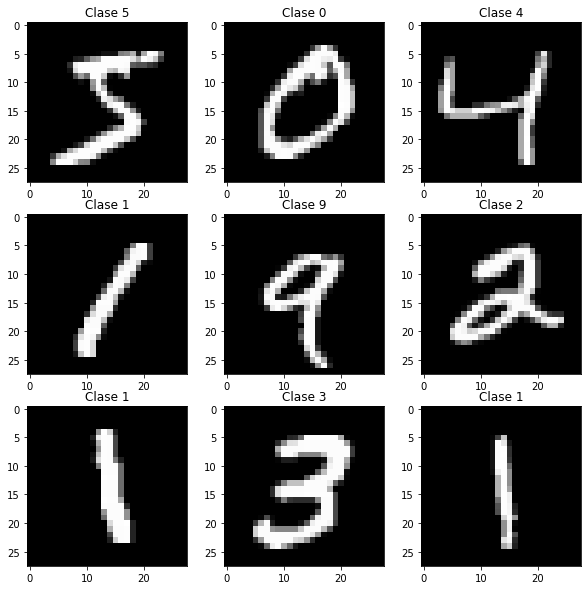

In [7]:
# Visualización de las imágenes
import matplotlib.pyplot as plt
# Configuramos tamaño de las imágenes para una correcta visualización
plt.rcParams['figure.figsize'] = (10, 10)
# Mostramos 9 imágenes con su etiqueta correspondiente
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_train[i], cmap='gray')
  plt.title(f'Clase {y_train[i]}')

# 2. Pre-proceso de los datos

In [8]:
# Para trabajar con redes neuronales totalmente conectadas no podemos trabajar con matrices 2D, debemos convertir la imagen a vector 1D
X_train_vector = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_testval_vector = X_testval.reshape(X_testval.shape[0], X_testval.shape[1]*X_testval.shape[2])
print("Nuevo tamaño datos entrenamiento: ", X_train_vector.shape)
print("Nuevo tamaño datos validación/test: ", X_testval_vector.shape)

Nuevo tamaño datos entrenamiento:  (60000, 784)
Nuevo tamaño datos validación/test:  (10000, 784)


In [9]:
# Las redes neuronales trabajan mejor con valores entre 0-1. Por lo que vamos a convertir el rango

# Primero convertimos las imágenes a float
X_train_vector = X_train_vector.astype('float32')
X_testval_vector = X_testval_vector.astype('float32')
print('Tipo datos entrenamiento: ', X_train_vector.dtype)
print('Tipo datos validación/test: ', X_testval_vector.dtype)

Tipo datos entrenamiento:  float32
Tipo datos validación/test:  float32


In [10]:
# Cambiamos rango de las imágenes
X_train_vector /= 255
X_testval_vector /= 255
print("Rango datos entrenamiento: [", X_train_vector.min(), ', ', X_train_vector.max(), ']')
print("Rango datos validación/test: [", X_testval_vector.min(), ', ', X_testval_vector.max(), ']')

Rango datos entrenamiento: [ 0.0 ,  1.0 ]
Rango datos validación/test: [ 0.0 ,  1.0 ]


In [11]:
# Convertimos etiquetas a codificación one-hot
from tensorflow.keras.utils import to_categorical
num_clases = len(np.unique(y_train))
y_train_cod = to_categorical(y_train, num_clases)
y_testval_cod = to_categorical(y_testval, num_clases)

In [12]:
print("Tamaño etiquetas entrenamiento: ", y_train_cod.shape)
print("Tamaño etiquetas validación/test: ", y_testval_cod.shape)

Tamaño etiquetas entrenamiento:  (60000, 10)
Tamaño etiquetas validación/test:  (10000, 10)


In [13]:
# Dividimos conjunto de datos de validación/test en 2 subconjuntos
samples_test_nb = int(X_testval.shape[0]/2)
X_val = X_testval_vector[:samples_test_nb]
y_val = y_testval_cod[:samples_test_nb]
X_test = X_testval_vector[samples_test_nb:]
y_test = y_testval_cod[samples_test_nb:]

print("Muestras validación: ", X_val.shape)
print("Muestras test: ", X_test.shape)

Muestras validación:  (5000, 784)
Muestras test:  (5000, 784)


# 3. Diseñamos la arquitectura


In [14]:
# Importamos dependencias
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [15]:
# Definimos la arquitectura
# Definimos arquitectura
input_layer = Input(shape=(X_train_vector.shape[1],))
hidden_layer = Dense(32, activation="relu")(input_layer)
output_layer = Dense(num_clases, activation="softmax")(hidden_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compilamos el modelo
model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

# 4. Entrenamiento de un modelo

In [17]:
history = model.fit(X_train_vector, y_train_cod, epochs=20, batch_size=128,
                    validation_data=(X_val, y_val))

Epoch 1/20
469/469 [==============================] - 4s 3ms/step - loss: 0.5278 - accuracy: 0.8568 - val_loss: 0.3456 - val_accuracy: 0.9000
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.2377 - accuracy: 0.9325 - val_loss: 0.2584 - val_accuracy: 0.9236
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1889 - accuracy: 0.9460 - val_loss: 0.2225 - val_accuracy: 0.9340
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1610 - accuracy: 0.9541 - val_loss: 0.1966 - val_accuracy: 0.9386
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1422 - accuracy: 0.9594 - val_loss: 0.1817 - val_accuracy: 0.9450
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1281 - accuracy: 0.9628 - val_loss: 0.1696 - val_accuracy: 0.9472
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1162 - accuracy: 0.9662 - val_loss: 0.1609 - val_accuracy: 0.9514
Epoch 

KeyboardInterrupt: ignored

Cosas a observar:

Métricas entrenamiento
Métricas validacón
¿Sobreajuste?

In [ ]:
# Visualizamos la precisión
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc="lower right")
plt.show()

In [ ]:
# Visualizamos pérdidas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdidas modelo')
plt.ylabel('Pérdidas')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc="upper left")
plt.show()

In [ ]:
# Guardamos el modelo
from pathlib import Path
path_modelos = Path('./modelos')
path_modelos.mkdir(exist_ok=True)
model.save(path_modelos / 'model_mnist.h5')

# 5. Evaluamos el modelo

In [ ]:
# Sacamos métricas sobre nuestro conjunto de test
metrics = model.evaluate(X_test, y_test, verbose=0)
print("Precision test: ", metrics[1])

In [ ]:
# Obtenemos predicciones 
prediccion = model.predict(X_test)
# Cogemos la clase con mayor probabilidad
prediccion = np.argmax(prediccion, axis=1)

In [ ]:
# Deshacemos codificación one-hot en conjunto de test
y_test_clases = np.argmax(y_test, axis=1)

In [ ]:
# Detectamos imágenes correctamente clasificadas
correct_index = np.nonzero(prediccion == y_test_clases)[0]

In [ ]:
# Detectamos imágenes incorrectamente clasificadas
incorrect_index = np.nonzero(prediccion != y_test_clases)[0]

In [ ]:
# Mostramos imágenes correctamente clasificadas
plt.figure()
for i, correct in enumerate(correct_index[:9]):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_test[correct].reshape(28,28), cmap='gray')
  plt.title(f'Real {y_test_clases[correct]}, Predicha {prediccion[correct]}')

In [ ]:
# Mostramos imágenes incorrectamente clasificadas
plt.figure()
for i, incorrect in enumerate(incorrect_index[:9]):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray')
  plt.title(f'Real {y_test_clases[incorrect]}, Predicha {prediccion[incorrect]}')

# Ejercicio 1: Probamos diferentes funciones de activación

Analizamos cómo afecta el uso de diferentes funciones de activación en la capa oculta. Probamos las siguientes:

*   Sin función de activación
*   Sigmoid
*   Tanh
*   Relu




In [ ]:
def crear_modelo(act):
  input_layer = Input(shape=(X_train_vector.shape[1],))
  hidden_layer = Dense(32, activation=act)(input_layer)
  output_layer = Dense(num_clases, activation="softmax")(hidden_layer)
  model = Model(inputs=input_layer, outputs=output_layer)
  return model

activacion=[None,"sigmoid","tanh","relu"]
history_ = {}
for act in activacion:
  crear_modelo(act)
  model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
  history_[str(act)] = model.fit(X_train_vector, y_train_cod, epochs=20, batch_size=128,
                    validation_data=(X_val, y_val),verbose=0)
  # Visualizamos la precisión
  import matplotlib.pyplot as plt
  plt.plot(history_[str(act)].history['accuracy'])
  plt.plot(history_[str(act)].history['val_accuracy'])
  plt.title('Precisión modelo')
  plt.ylabel('Precisión')
  plt.xlabel('Época')
  plt.title(act)
  plt.legend(['Entrenamiento', 'Validación'], loc="lower right")
  plt.show()


  

# Ejercicio 2: Creamos un modelo más complejo
Para aumentar la complejidad del modelo añadimos una capa oculta de 512 neuronas

In [ ]:
# Definimos la arquitectura
# Definimos arquitectura
input_layer = Input(shape=(X_train_vector.shape[1],))
hidden_layer = Dense(512, activation="relu")(input_layer)
output_layer = Dense(num_clases, activation="softmax")(hidden_layer)

model_comp = Model(inputs=input_layer, outputs=output_layer)
model.summary()

model_comp.compile(loss="categorical_crossentropy", optimizer="adam",
            metrics=["accuracy"])
history_compleja = model_comp.fit(X_train_vector, y_train_cod, epochs=20, batch_size=128,
                    validation_data=(X_val, y_val),verbose=0)

plt.plot(history_compleja.history['accuracy'])
plt.plot(history_compleja.history['val_accuracy'])
plt.title('Precisión modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.title(act)
plt.legend(['Entrenamiento', 'Validación'], loc="lower right")
plt.show()

In [ ]:
# Visualizamos pérdidas
plt.plot(history_compleja.history['loss'])
plt.plot(history_compleja.history['val_loss'])
plt.title('Pérdidas modelo')
plt.ylabel('Pérdidas')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc="upper left")
plt.show()

# Ejercicio 3: Entrenamos un modelo con la base de datos CIFAR10

In [18]:
from keras.datasets import cifar10

170498071/170498071 [==============================] - 15s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5
1563/1563 [==============================] - 13s 5ms/step - loss: 1.3429 - accuracy: 0.5263 - val_loss: 1.0826 - val_accuracy: 0.6234
Epoch 2/5
1563/1563 [==============================] - 7s 4ms/step - loss: 1.0126 - accuracy: 0.6499 - val_loss: 1.0158 - val_accuracy: 0.6537
Epoch 3/5
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9078 - accuracy: 0.6881 - val_loss: 0.9705 - val_accuracy: 0.6665
Epoch 4/5
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8359 - accuracy: 0.7130 - val_loss: 0.9570 - val_accuracy: 0.6736
Epoch 5/5
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7825 - accuracy: 0.7292 - val_loss: 0.9583 - val_accuracy: 0.6753


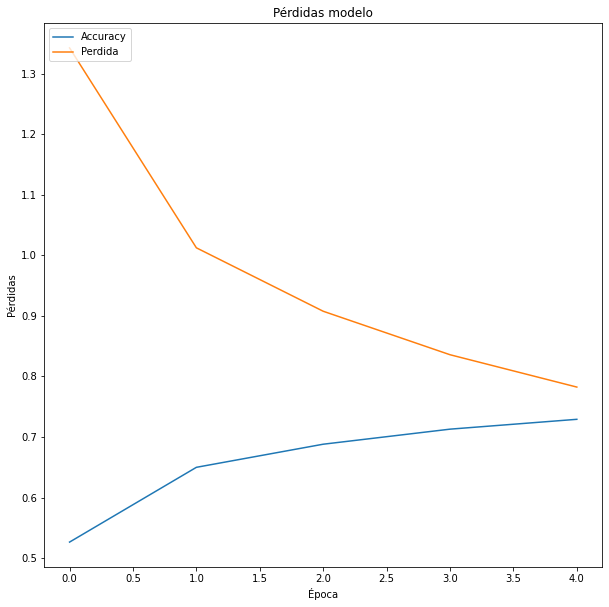

Test loss: 0.9582804441452026
Test accuracy: 0.6753000020980835


In [19]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation, Flatten

from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer="adam",
            metrics=["accuracy"])
history_cifar = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)

plt.plot(history_cifar.history['accuracy'])
plt.plot(history_cifar.history['loss'])
plt.title('Pérdidas modelo')
plt.ylabel('Pérdidas')
plt.xlabel('Época')
plt.legend(['Accuracy', 'Perdida'], loc="upper left")
plt.show()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save('model.h5')



